In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

import tensorflow as tf
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras.optimizers import Adam

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Reshape, LSTM
from keras import backend as K
import itertools
#from tensorflow.keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.callbacks import EarlyStopping, ModelCheckpoint

#from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [2]:
sns.set_style('darkgrid')

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/skin-cancer-mnist-ham10000/hmnist_8_8_RGB.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_8_8_L.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_L.csv
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028933.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028394.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027799.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028100.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027960.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028872.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0026412.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024872.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000

In [4]:
base_skin_dir = os.path.join('..', 'input/skin-cancer-mnist-ham10000')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [5]:
skin_df = pd.read_csv('../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')

# Creating New Columns for better readability
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [6]:
skin_df.sample(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
9098,HAM_0004991,ISIC_0028809,nv,histo,65.0,male,back,../input/skin-cancer-mnist-ham10000/ham10000_i...,Melanocytic nevi,4
3266,HAM_0004623,ISIC_0024746,nv,follow_up,50.0,male,abdomen,../input/skin-cancer-mnist-ham10000/ham10000_i...,Melanocytic nevi,4
6438,HAM_0006263,ISIC_0029447,nv,follow_up,40.0,male,back,../input/skin-cancer-mnist-ham10000/ham10000_i...,Melanocytic nevi,4
259,HAM_0001309,ISIC_0033629,bkl,histo,60.0,female,lower extremity,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
3374,HAM_0000003,ISIC_0027886,nv,follow_up,55.0,male,trunk,../input/skin-cancer-mnist-ham10000/ham10000_i...,Melanocytic nevi,4
7186,HAM_0005300,ISIC_0033625,nv,histo,35.0,female,lower extremity,../input/skin-cancer-mnist-ham10000/ham10000_i...,Melanocytic nevi,4
5707,HAM_0001210,ISIC_0025841,nv,follow_up,40.0,male,lower extremity,../input/skin-cancer-mnist-ham10000/ham10000_i...,Melanocytic nevi,4
4540,HAM_0001659,ISIC_0026564,nv,follow_up,35.0,male,lower extremity,../input/skin-cancer-mnist-ham10000/ham10000_i...,Melanocytic nevi,4
7607,HAM_0001511,ISIC_0033683,nv,histo,30.0,female,back,../input/skin-cancer-mnist-ham10000/ham10000_i...,Melanocytic nevi,4
6295,HAM_0000307,ISIC_0027011,nv,follow_up,65.0,male,back,../input/skin-cancer-mnist-ham10000/ham10000_i...,Melanocytic nevi,4


In [7]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [8]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

In [9]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [10]:
skin_df.to_csv('df_main.csv')

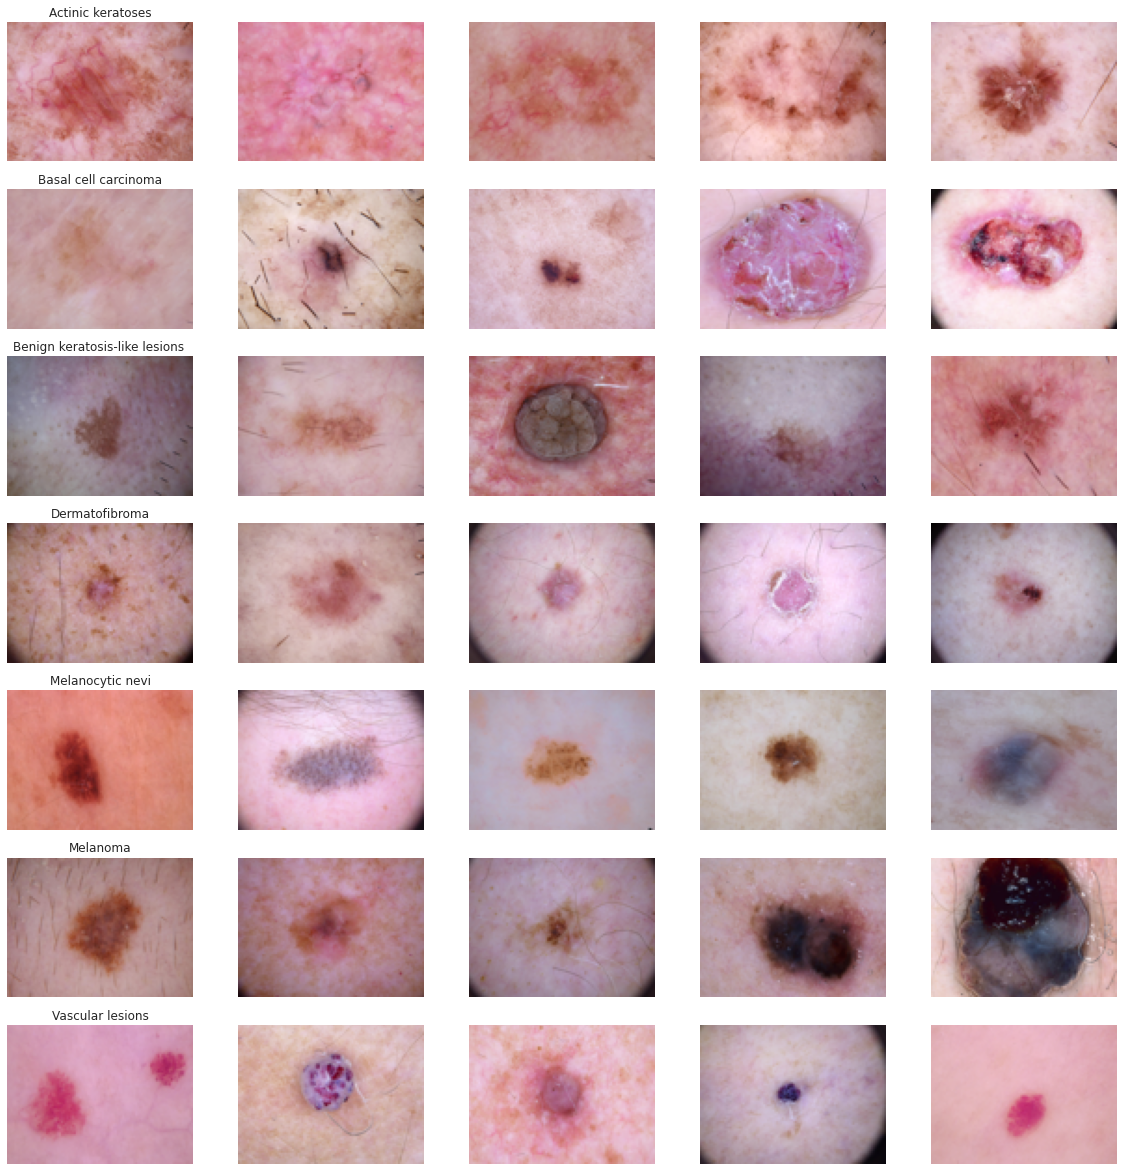

In [11]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [12]:
#skin_df = pd.read_csv('../input/ham10000/df_main.csv')

In [13]:
# skin_df.sample(10)

In [14]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

In [15]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=23)

In [16]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [17]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [18]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 23)

In [19]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [20]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [21]:
input_shape = (75, 100, 3)
num_classes = 7
model = Sequential()
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu',input_shape = input_shape))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu',))
model.add(BatchNormalization())
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(num_classes,activation = 'softmax'))
#model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

2023-02-03 17:40:20.979201: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-03 17:40:21.107731: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-03 17:40:21.108814: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-03 17:40:21.112291: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [22]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 75, 100, 64)       1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 75, 100, 64)       256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 100, 64)       36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 100, 64)       256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 50, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 50, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 37, 50, 128)       5

In [24]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [25]:
early_stop = EarlyStopping(monitor='val_loss', patience=6)
mod_chckpt = ModelCheckpoint(filepath='model_v1_rms.h5', monitor='val_loss', save_best_only=True)

In [26]:
epochs = 25
batch_size = 50

history= model.fit(datagen.flow(x_train,y_train, batch_size=batch_size),
                                epochs = epochs, validation_data = (x_validate,y_validate),
                                verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size,
                                callbacks=[learning_rate_reduction, early_stop, mod_chckpt])

2023-02-03 17:40:25.575550: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


2023-02-03 17:40:27.565817: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


144/144 [==============================] - 25s 112ms/step - loss: 1.3025 - accuracy: 0.6081 - val_loss: 1.3214 - val_accuracy: 0.6259
Epoch 2/25
144/144 [==============================] - 15s 105ms/step - loss: 0.8017 - accuracy: 0.7145 - val_loss: 1.1557 - val_accuracy: 0.6808
Epoch 3/25
144/144 [==============================] - 15s 105ms/step - loss: 0.7644 - accuracy: 0.7208 - val_loss: 0.9480 - val_accuracy: 0.6945
Epoch 4/25
144/144 [==============================] - 16s 110ms/step - loss: 0.7158 - accuracy: 0.7399 - val_loss: 0.8342 - val_accuracy: 0.7244
Epoch 5/25
144/144 [==============================] - 15s 106ms/step - loss: 0.6865 - accuracy: 0.7476 - val_loss: 0.9068 - val_accuracy: 0.6584
Epoch 6/25
144/144 [==============================] - 16s 109ms/step - loss: 0.6832 - accuracy: 0.7487 - val_loss: 0.8150 - val_accuracy: 0.6983
Epoch 7/25
144/144 [==============================] - 16s 109ms/step - loss: 0.6642 - accuracy: 0.7552 - val_loss: 0.7867 - val_accuracy: 0.7

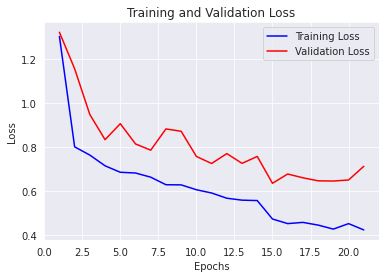

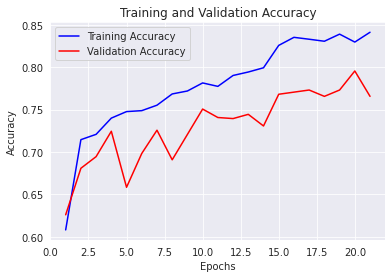

In [27]:
history_dict = history.history
loss_value = history_dict['loss']
val_loss_value = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
epochs = range(1, len(loss_value) + 1)
plt.plot(epochs, loss_value, 'b', label='Training Loss')
plt.plot(epochs, val_loss_value, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_adam.png')
plt.show()

plt.figure()

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('acc_adam.png')
plt.show()

In [28]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save('adam_model.h5')

26/26 [==============================] - 0s 10ms/step - loss: 0.7135 - accuracy: 0.7656
Validation: accuracy = 0.765586  ;  loss_v = 0.713475
Test: accuracy = 0.761857  ;  loss = 0.711165


In [29]:
print(f"Predicted {np.argmax(model.predict(x_test[15].reshape(-1,75,100,3)))}\nActual {np.argmax(y_test[15])}")

Predicted 5
Actual 5


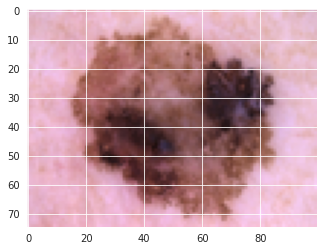

In [30]:
plt.imshow(((x_test[15]*x_test_std)+x_test_mean).astype('int'))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  if sys.path[0] == '':


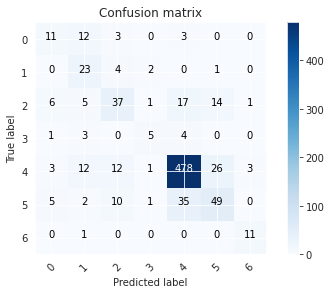

In [31]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

Text(0, 0.5, 'Fraction classified incorrectly')

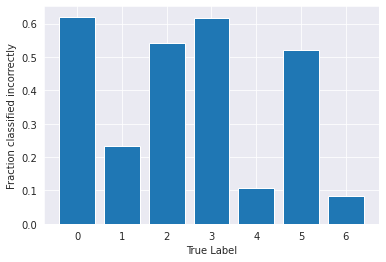

In [32]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

$$
\begin{bmatrix}
    \hline
    \mathtt{optimizer} & \mathtt{test~accuracy} & \mathtt{test~loss} \\
    \hline 
    adam & 0.781 & 0.65 \\  
    rmsprop & 0.776 & 0.63 \\ 
    sgd & 0.734 & 0.69 \\
    adagrad & 0.74 & 0.68 \\
    Nadam & 0.7653 & 0.67 \\ 
    \hline
\end{bmatrix}
$$

In [33]:
# from keras.models import Model
# from numpy import expand_dims
# from keras.applications.vgg16 import preprocess_input
# from keras.preprocessing.image import img_to_array
# # redefine model to output right after the first hidden layer
# model_1 = Model(inputs=model.inputs, outputs=model.layers[1].output)
# model_1.summary()
# # load the image with the required shape
# #img = load_img('bird.jpg', target_size=(75,100))
# # convert the image to an array
# img = img_to_array(((x_test[0]*x_test_std)+x_test_mean).astype('int'))
# # expand dimensions so that it represents a single 'sample'
# img = expand_dims(img, axis=0)
# # prepare the image (e.g. scale pixel values for the vgg)
# img = preprocess_input(img)
# # get feature map for first hidden layer
# feature_maps = model.predict(img)
# # plot all 64 maps in an 8x8 squares
# square = 8
# ix = 1
# for _ in range(square):
# 	for _ in range(square):
# 		# specify subplot and turn of axis
# 		ax = plt.subplot(square, square, ix)
# 		ax.set_xticks([])
# 		ax.set_yticks([])
# 		# plot filter channel in grayscale
# 		plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
# 		ix += 1
# # show the figure
# plt.show()

In [34]:
model2 = Sequential()
model2.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu',input_shape = input_shape))
model2.add(BatchNormalization())
model2.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size = (2,2)))
model2.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.4))
model2.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size = (2,2)))
model2.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu',))
model2.add(BatchNormalization())
model2.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size = (2,2)))
#model2.add(Dropout(0.5))
model2.add(Flatten())
model2.add(Reshape((9*16,192)))
model2.add(LSTM(units=32))
model2.add(Dense(64, activation = 'relu'))
model2.add(BatchNormalization())
model2.add(Dense(num_classes,activation = 'softmax'))

In [35]:
optimizer2 = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model2.compile(optimizer = optimizer2 , loss = "categorical_crossentropy", metrics=["accuracy"])

In [36]:
epochs = 25
batch_size = 50

history2= model2.fit(datagen.flow(x_train,y_train, batch_size=batch_size),
                                epochs = epochs, validation_data = (x_validate,y_validate),
                                verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size,
                                callbacks=[learning_rate_reduction, early_stop, mod_chckpt])

Epoch 1/25
144/144 [==============================] - 19s 114ms/step - loss: 1.4772 - accuracy: 0.5320 - val_loss: 1.2006 - val_accuracy: 0.6671
Epoch 2/25
144/144 [==============================] - 16s 110ms/step - loss: 1.0225 - accuracy: 0.6591 - val_loss: 1.0357 - val_accuracy: 0.6683
Epoch 3/25
144/144 [==============================] - 16s 107ms/step - loss: 1.0009 - accuracy: 0.6589 - val_loss: 1.0128 - val_accuracy: 0.6571
Epoch 4/25
144/144 [==============================] - 17s 117ms/step - loss: 0.9634 - accuracy: 0.6677 - val_loss: 0.9824 - val_accuracy: 0.6671
Epoch 5/25
144/144 [==============================] - 15s 105ms/step - loss: 0.9445 - accuracy: 0.6675 - val_loss: 0.9198 - val_accuracy: 0.6783
Epoch 6/25
144/144 [==============================] - 17s 116ms/step - loss: 0.9014 - accuracy: 0.6746 - val_loss: 0.9449 - val_accuracy: 0.6920
Epoch 7/25
144/144 [==============================] - 15s 105ms/step - loss: 0.8718 - accuracy: 0.6863 - val_loss: 0.9168 - val_ac

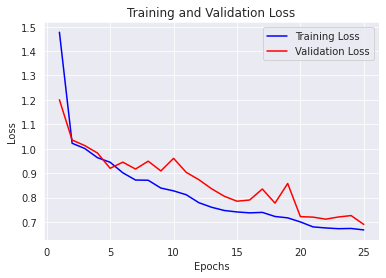

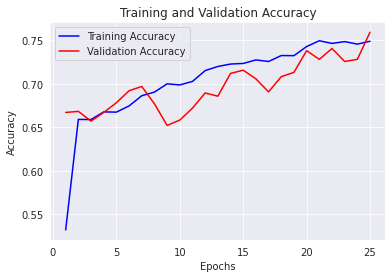

In [37]:
history_dict = history2.history
loss_value = history_dict['loss']
val_loss_value = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
epochs = range(1, len(loss_value) + 1)
plt.plot(epochs, loss_value, 'b', label='Training Loss')
plt.plot(epochs, val_loss_value, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_lstm.png')
plt.show()

plt.figure()

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('acc_lstm.png')
plt.show()

In [38]:
loss, accuracy = model2.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model2.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save('lstm_model.h5')

26/26 [==============================] - 0s 12ms/step - loss: 0.6899 - accuracy: 0.7594
Validation: accuracy = 0.759352  ;  loss_v = 0.689927
Test: accuracy = 0.741388  ;  loss = 0.695967


In [39]:
print(f"Predicted {np.argmax(model2.predict(x_test[13].reshape(-1,75,100,3)))}\nActual {np.argmax(y_test[13])}")

Predicted 4
Actual 4
